# <h1><center>Battle of the Neighbourhoods</center></h1> 

##### Author: Carl-Michael Edeling

---

### Problem Description:

An Italian Restaurant is looking to open another branch due to their continued success. It is located in Sandton, Johannesburg, South Africa, and is looking to open the second branch in a neighborhood similar to Sandton.

This project would be for any kind of business (in any area) that is looking to either open a second location or needs to relocate their business



### Potential Data Required:

1. Local Traffic Information
2. Local Weather Information
3. Local POI Information
4. Demographic Information

---

Import Useful Libraries

In [467]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [468]:
import pandas as pd
import numpy as np
import requests
import os
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


---

# Plan going forward

1. Find Data
2. Clean Data
3. Create Relavant Databases
4. Create Models
5. Select most effective values
6. Create Graphics
7. Summarize and Report

The problem is to find neighbourhoods similar to Sandton. 

So first create a list of neighbourhoods with latitudes and longitudes to pass to 4square.  Once that is done, find traffic, weather and demographic info to add to that DF.  Once all that is done then you can analyze and model.

---

# Get a list of Suburbs in Johannesburg

This was surprizingly difficult.  I tried using Wikipedia and various property rental sites, with varied success in the webscraping.  Then I realized that webscraping is easier than some methods, but not in this case.  So I found the suburbs as a string, copied it into a text editor and created a csv file.

If the cell labelled "import csv with suburb data" stops due to error, un-comment the next 2 cells and run them.

In [469]:
# %reset

In [470]:
"""import pandas as pd
import numpy as np
import requests
import os
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

print('Libraries imported.')"""

"import pandas as pd\nimport numpy as np\nimport requests\nimport os\nimport requests\nimport matplotlib.cm as cm\nimport matplotlib.colors as colors\nimport folium \nimport json\n\npd.set_option('display.max_columns', None)\npd.set_option('display.max_rows', None)\n\nfrom geopy.geocoders import Nominatim\nfrom pandas.io.json import json_normalize\nfrom sklearn.cluster import KMeans\nfrom bs4 import BeautifulSoup\n\nprint('Libraries imported.')"

Import the suburb names.

In [471]:
#"import csv with suburb data"

import csv

with open('suburbs3.csv', newline='') as peach:
    reader1 = csv.reader(peach)
    data1 = list(reader1)

print(data1)

[['Suburbs'], [' Brakpan'], [' Daveyton'], [' Roodepoort'], [' Westonaria'], [' Sandton'], [' Randburg'], [' Rivonia'], [' Ruimsig'], [' Fourways'], [' Edenvale'], [' Bedfordview'], [' Southgate'], [' Auckland Park'], [' Germiston'], [' Northcliff'], [' Bryanston'], [' Fairland'], [' Honeydew'], [' Houghton'], [' Hyde Park'], [' Kensington'], [' Linden'], [' Melville'], [' Morningside'], [' Saxonwold'], [' Illovo'], [' Rosebank'], [' Melrose'], [' Mondeor'], [' Westdene'], [' Parkview'], [' Lanseria'], [' Parktown'], [' Lyndhurst'], [' Braamfontein'], [' Greenside'], [' Lonehill'], [' Kyalami'], [' Soweto'], [' Norwood'], [' North Riding'], [' Winchester Hills'], [' Cresta'], [' Eikenhof'], [' Bramley'], [' Isando'], [' Lenasia'], [' Kempton Park'], [' Midrand'], [' Benoni'], [' Boksburg'], [' Alberton'], [' Randfontein'], [' Springs']]


In [472]:
for sub in data1:
    sub = str(sub).strip(" ")

In [473]:
data1[0:5]

[['Suburbs'], [' Brakpan'], [' Daveyton'], [' Roodepoort'], [' Westonaria']]

Get the latitudes and longitudes of each suburb using Nominatim GeoCode.

In [474]:
latitudes = []
longitudes = []

In [475]:
import geocoder
import numpy as np
import geopy
from geopy.geocoders import Nominatim

locator = Nominatim(user_agent="cmedeling")
for sub in data1:
    location = locator.geocode("{}, Johannesburg".format(sub))
    
    try:
        #print(location.latitude, location.longitude)
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    except: 
        #print('NaN')
        latitudes.append(np.nan)
        longitudes.append(np.nan)
print("Done!")

Done!


Create a dataframe of suburbs, along with their latitudes and longitudes.

In [476]:
df = pd.DataFrame(columns = ("Suburb", "Latitude", "Longitude"))

In [477]:
for i in range(len(latitudes)):
    df.loc[i,"Suburb"] = data1[i]
    df.loc[i,"Latitude"] = latitudes[i]
    df.loc[i,"Longitude"] = longitudes[i]

In [478]:
df.head()

,Suburb,Latitude,Longitude
0,[Suburbs],50.847,9.70062
1,[ Brakpan],NaN,NaN
2,[ Daveyton],NaN,NaN
3,[ Roodepoort],-26.1908,27.9486
4,[ Westonaria],-26.3492,27.7731


Inspecting the dataframe, we see that not all suburbs received their latitudes and longitudes.  Depending on the scope of the project it may be necessary to find their coordinates manually or through another method.  However, for this project it is not necessary, so we will drop these suburbs instead.

In [479]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
df.drop(0, axis = 0, inplace = True)
#df.shape


In [480]:
df.head()

,Suburb,Latitude,Longitude
3,[ Roodepoort],-26.1908,27.9486
4,[ Westonaria],-26.3492,27.7731
5,[ Sandton],-26.1047,28.045
6,[ Randburg],-26.0961,27.975
7,[ Rivonia],-26.1166,28.0464


# DONE!

---

# Using the location data with the Four Square API

#### So what is the plan?

Since it is a restaurant, we need to know if there are other restaurants in the area which will help ensure that there is a relatively high amount of foot-traffic and exposure.  

So let's use a radius of 10km from the center of the suburb.

We will get a list of venues for the given latitudes and longitudes.  From this list, we need to find areas with a higher frequency of restaurants.

___

# Create a Map of Johannesburg

In [481]:
locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode("Sandton, Johannesburg")

In [482]:
latitude = location.latitude
longitude = location.longitude

In [483]:
latitude, longitude

(-26.1047491, 28.0450011)

In [484]:
# create map of Toronto using latitude and longitude values
map_joburg = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, sub in zip(df['Latitude'], 
                         df['Longitude'], 
                         df['Suburb']):
    label = '{}'.format(sub)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_joburg)  
    
map_joburg

---

# Get Nearby Venues using FourSquare

Define Foursquare Credentials:

In [485]:
CLIENT_ID = 'DG3NWU3U0KEFYBAI1DFVV1XBNNINC4Q3JWHE44W3M3XJUAE2' # your Foursquare ID
CLIENT_SECRET = 'POVT0GBHKR4DWJIBHXVUEB4FOXJLQY3NHC1VQOP3YZTXPPIG' # your Foursquare Secret
ACCESS_TOKEN = 'PB3FDE2RW4DU3NFGLXD2YWD2IBANYW3RJPAGZATESDJZD3XM' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DG3NWU3U0KEFYBAI1DFVV1XBNNINC4Q3JWHE44W3M3XJUAE2
CLIENT_SECRET:POVT0GBHKR4DWJIBHXVUEB4FOXJLQY3NHC1VQOP3YZTXPPIG


Get nearby venues for each neighbourhood.

In [486]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [487]:
joburg_venues = getNearbyVenues(names=df['Suburb'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])
print("Done!")

Done!


In [488]:
print("The shape is: ", joburg_venues.shape)
joburg_venues.head()

The shape is:  (1426, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,[ Roodepoort],-26.190752,27.948572,Food Lovers Market,-26.141281,27.921980,Farmers Market
1,[ Roodepoort],-26.190752,27.948572,Roco Mama's,-26.136848,27.918554,Burger Joint
2,[ Roodepoort],-26.190752,27.948572,Emmarentia Park,-26.160176,28.004150,Dog Run
3,[ Roodepoort],-26.190752,27.948572,44 Stanley Ave,-26.185426,28.018887,Arts & Crafts Store
4,[ Roodepoort],-26.190752,27.948572,The Whippet In Linden,-26.140260,27.992015,Coffee Shop


Try to get number of Italian Restaurants by suburb.

I get an error when trying to group suburbs together to get counts of venues because Suburbs is treated as a list which is unhashable.  To get around this, apply a lambda function to Suburbs, turning them into hashable tuple.

In [489]:
joburg_venues['Suburb'] = joburg_venues['Suburb'].apply(lambda x: tuple(x))
joburg_venues.head()

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"( Roodepoort,)",-26.190752,27.948572,Food Lovers Market,-26.141281,27.921980,Farmers Market
1,"( Roodepoort,)",-26.190752,27.948572,Roco Mama's,-26.136848,27.918554,Burger Joint
2,"( Roodepoort,)",-26.190752,27.948572,Emmarentia Park,-26.160176,28.004150,Dog Run
3,"( Roodepoort,)",-26.190752,27.948572,44 Stanley Ave,-26.185426,28.018887,Arts & Crafts Store
4,"( Roodepoort,)",-26.190752,27.948572,The Whippet In Linden,-26.140260,27.992015,Coffee Shop


In [491]:
joburg_venues[joburg_venues['Venue Category'] == "Italian Restaurant"].count()

Suburb              62
Suburb Latitude     62
Suburb Longitude    62
Venue               62
Venue Latitude      62
Venue Longitude     62
Venue Category      62
dtype: int64

In [492]:
condition = joburg_venues[joburg_venues['Venue Category'] == "Italian Restaurant"]

total_venue_categories = condition.groupby("Suburb").count()
num_ital_rest_by_sub = pd.DataFrame(total_venue_categories['Venue Category'])
num_ital_rest_by_sub

,Venue Category
Suburb,
"( Bedfordview,)",1
"( Bramley,)",2
"( Bryanston,)",2
"( Cresta,)",1
"( Edenvale,)",2
"( Eikenhof,)",3
"( Fairland,)",3
"( Fourways,)",2
"( Greenside,)",1


In [493]:
num_ital_rest_by_sub[num_ital_rest_by_sub['Venue Category'] == 1]

,Venue Category
Suburb,
"( Bedfordview,)",1
"( Cresta,)",1
"( Greenside,)",1
"( Houghton,)",1
"( Linden,)",1
"( Lyndhurst,)",1
"( Melrose,)",1
"( Morningside,)",1
"( Norwood,)",1


This is an indicator of flawed data.  The above dataframe shows that these suburbs each only have 1 restaurant.  This is incorrect which can be confirmed quickly with a Google search.

The problem could be with 2 things:

1. Either I messed up the counts
2. The venue data returned from Four Square doesn't include data for all venues.

This can be tested.  If I sum up all these counts, it should be the same as if I count all the Italian Restaurants in Venue Categories.

Let's test.

In [494]:
num_ital_rest_by_sub.count()

Venue Category    35
dtype: int64

In [495]:
joburg_venues[joburg_venues['Venue Category'] == "Italian Restaurant"].count()

Suburb              62
Suburb Latitude     62
Suburb Longitude    62
Venue               62
Venue Latitude      62
Venue Longitude     62
Venue Category      62
dtype: int64

The above shows that there is a problem with how I counted.  The above shows that there should be 62 Italian Restaurants in Johannesburg, whereas I've only included 35.

In [496]:
sum(num_ital_rest_by_sub["Venue Category"])

62

That's better.  

# DONE!

___

# Which venues are restaurants?

"joburg_venues" contains a list of all the venues

In [497]:
joburg_venues.head()

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"( Roodepoort,)",-26.190752,27.948572,Food Lovers Market,-26.141281,27.921980,Farmers Market
1,"( Roodepoort,)",-26.190752,27.948572,Roco Mama's,-26.136848,27.918554,Burger Joint
2,"( Roodepoort,)",-26.190752,27.948572,Emmarentia Park,-26.160176,28.004150,Dog Run
3,"( Roodepoort,)",-26.190752,27.948572,44 Stanley Ave,-26.185426,28.018887,Arts & Crafts Store
4,"( Roodepoort,)",-26.190752,27.948572,The Whippet In Linden,-26.140260,27.992015,Coffee Shop


In [498]:
len(joburg_venues)

1426

Let's create a dataframe of restaurants in Johannesburg.

In [499]:
restaurants = []
restaurants = pd.DataFrame(columns = ["Suburb", "Suburb Latitude", "Suburb Longitude", "Venue", "Venue Latitude", "Venue Longitude", "Venue Category"])
restaurants
#df = pd.DataFrame(columns = ("Suburb", "Latitude", "Longitude"))

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


I decided to find a list of restaurants by removing non-restaurant venue.

In [500]:
non_restaurant_venues = joburg_venues[~joburg_venues["Venue Category"].str.contains("estaurant")]
len(non_restaurant_venues)

1069

In [501]:
restaurant_venues = pd.concat([joburg_venues, non_restaurant_venues]).drop_duplicates(keep = False)
restaurant_venues = restaurant_venues.reset_index()
restaurant_venues.head()

,index,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,12,"( Roodepoort,)",-26.190752,27.948572,Dosa Hut,-26.205367,28.021918,Indian Restaurant
1,14,"( Roodepoort,)",-26.190752,27.948572,Vilakazi Restaurant,-26.237942,27.903352,African Restaurant
2,19,"( Roodepoort,)",-26.190752,27.948572,Lucky Bean,-26.175554,28.008887,African Restaurant
3,21,"( Roodepoort,)",-26.190752,27.948572,Spiceburg,-26.146415,28.008942,Indian Restaurant
4,25,"( Roodepoort,)",-26.190752,27.948572,Olives & Plates WITS,-26.185774,28.025735,Restaurant


In [502]:
len(restaurant_venues)

357

In [503]:
unique_restaurant_categories = restaurant_venues['Venue Category'].unique()
print("The unique restaurant categories are :",  "\n\n" , "{}".format(unique_restaurant_categories))

The unique restaurant categories are : 

 ['Indian Restaurant' 'African Restaurant' 'Restaurant' 'Asian Restaurant'
 'Italian Restaurant' 'Fast Food Restaurant' 'Portuguese Restaurant'
 'Seafood Restaurant' 'Tapas Restaurant' 'Chinese Restaurant'
 'German Restaurant' 'Mexican Restaurant' 'Vegetarian / Vegan Restaurant'
 'Sushi Restaurant' 'Ethiopian Restaurant' 'Middle Eastern Restaurant'
 'Greek Restaurant' 'Mediterranean Restaurant' 'American Restaurant'
 'Modern European Restaurant' 'Molecular Gastronomy Restaurant'
 'Latin American Restaurant' 'Southern / Soul Food Restaurant'
 'Thai Restaurant' 'Eastern European Restaurant' 'Turkish Restaurant'
 'French Restaurant']


# Plan going forward:

Now that I have some basic restaurant info, I want to:

Use one hot coding to find:

1. Which suburbs have a comparable number of restaurants to Sandton.
2. Of those suburbs, which have the highest frequency of Italian Restaurants


In [504]:
# one hot encoding
joburg_onehot = pd.get_dummies(restaurant_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
joburg_onehot['Suburb'] = restaurant_venues['Suburb'] 

# move neighbourhood column to the first column
fixed_columns = [joburg_onehot.columns[-1]] + list(joburg_onehot.columns[:-1])
joburg_onehot = joburg_onehot[fixed_columns]

In [505]:
joburg_onehot.head()

,Suburb,African Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Portuguese Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,"( Roodepoort,)",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"( Roodepoort,)",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"( Roodepoort,)",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"( Roodepoort,)",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"( Roodepoort,)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [506]:
joburg_onehot.shape

(357, 28)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [507]:
joburg_grouped = joburg_onehot.groupby('Suburb').mean().reset_index()
joburg_grouped.head()

,Suburb,African Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Portuguese Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,"( Auckland Park,)",0.250000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,"( Bedfordview,)",0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.111111,0.222222,0.111111,0.111111,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.222222,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0
2,"( Braamfontein,)",0.166667,0.000,0.166667,0.0,0.0,0.166667,0.0,0.0,0.000000,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,"( Bramley,)",0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.142857,0.000000,0.285714,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.285714,0.0,0.000000,0.0,0.0,0.0,0.0
4,"( Bryanston,)",0.000000,0.125,0.000000,0.0,0.0,0.000000,0.0,0.0,0.125000,0.000000,0.250000,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0


A function to sort the venues in descending order.

In [508]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighbourhood.

In [509]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Suburb'] = joburg_grouped['Suburb']

for ind in np.arange(joburg_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(joburg_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"( Auckland Park,)",Indian Restaurant,African Restaurant,Restaurant,Latin American Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant
1,"( Bedfordview,)",Restaurant,Greek Restaurant,Italian Restaurant,Sushi Restaurant,Middle Eastern Restaurant,German Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Asian Restaurant
2,"( Braamfontein,)",Restaurant,African Restaurant,Asian Restaurant,Ethiopian Restaurant,Indian Restaurant,Latin American Restaurant,American Restaurant,Chinese Restaurant,Eastern European Restaurant,Fast Food Restaurant
3,"( Bramley,)",Italian Restaurant,Seafood Restaurant,Restaurant,Middle Eastern Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant
4,"( Bryanston,)",Italian Restaurant,Indian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant


The following suburbs have "Italian Restaurant" as the "1st Most Common Venue"

In [510]:
ital_subs = neighbourhoods_venues_sorted[neighbourhoods_venues_sorted["1st Most Common Venue"] == "Italian Restaurant"]['Suburb']
ital_subs

3              ( Bramley,)
4            ( Bryanston,)
7             ( Eikenhof,)
8             ( Fairland,)
9             ( Fourways,)
12            ( Honeydew,)
18             ( Kyalami,)
22            ( Lonehill,)
26             ( Midrand,)
28         ( Morningside,)
29        ( North Riding,)
30          ( Northcliff,)
34            ( Randburg,)
39             ( Ruimsig,)
44             ( Springs,)
47    ( Winchester Hills,)
Name: Suburb, dtype: object

This list will be used as a guide.  Maybe once k-Means has been run, it can be used to check if a suggested suburb is in this list.

# DONE!

---

# Cluster Neighbourhoods

Before we add other data, let's have a look at how the suburbs are clustered based purely on the data received from Four Square.

Run _k_-means to cluster the neighbourhood into 10 clusters.


In [511]:
# set number of clusters
kclusters = 10

joburg_grouped_clustering = joburg_grouped.drop('Suburb', 1)

test_kmeans = KMeans(n_clusters=kclusters, 
                init='k-means++', 
                n_init=100,
                max_iter=5000,
                tol=0.001, 
                random_state=12)
test_labels = test_kmeans.fit_predict(joburg_grouped_clustering)
test_labels

array([2, 0, 2, 7, 3, 6, 1, 1, 5, 1, 0, 6, 5, 7, 4, 4, 1, 0, 5, 9, 8, 6,
       5, 7, 7, 2, 3, 1, 3, 1, 5, 7, 9, 9, 5, 7, 4, 2, 7, 3, 4, 9, 1, 1,
       3, 2, 8, 1])

### What is the optimal value of k?

I tried to calculate the efficacy of using various numbers of clusters, ranging from 2 to 20.

I tried 2 methods:

1. Method - model.score()
2. Attribute - model.inertia_

#### Using .score() 

"Opposite of the value of X on the K-means objective."

By comparing it to inertia, it gives the negative of the inertia.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [512]:
kclusters = 20
kscores = []
for k in range(2, kclusters):
    kscore = KMeans(n_clusters=k, 
                init='k-means++', 
                n_init=100,
                max_iter=3000,
                tol=0.01, 
                random_state=7).fit(joburg_grouped_clustering).score(joburg_grouped_clustering, 
                                                                      y=None, 
                                                                      sample_weight=None)
    kscores.append(kscore)
    #print(kscore1)
print("The k-Scores are:", kscores)

The k-Scores are: [-5.294634300452253, -4.470472050571348, -3.9265956046623693, -3.492548702042364, -3.121806311467798, -2.7774653196397416, -2.522567375614376, -2.3223982807244634, -2.140174437263646, -1.9807327965730868, -1.83821138059929, -1.729307730989549, -1.6085476554219789, -1.4810414329554396, -1.3684487878727147, -1.238652869505368, -1.1632310114128297, -1.0693534603924217]


#### Using .inertia_

"Sum of squared distances of samples to their closest cluster center."

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [513]:
kclusters = 20
kinertia = []
for k in range(2, kclusters):
    kscore = KMeans(n_clusters=k, 
                init='k-means++', 
                n_init=100,
                max_iter=3000,
                tol=0.01, 
                random_state=7).fit(joburg_grouped_clustering)
    kinertia.append(kscore.inertia_)
    #print(kscore1)
print("The k-Inertias are:", kinertia)


The k-Inertias are: [5.294634300452253, 4.470472050571348, 3.9265956046623693, 3.4925487020423636, 3.121806311467799, 2.777465319639742, 2.522567375614376, 2.3223982807244634, 2.1401744372636453, 1.9807327965730868, 1.8382113805992897, 1.729307730989549, 1.6085476554219789, 1.4810414329554396, 1.3684487878727147, 1.238652869505368, 1.1632310114128297, 1.0693534603924217]


On inspection of the values of Inertia and kscores, we can see that they are the same absolute values.

Let's graph number of clusters against kscores and kinertia

In [514]:
x = np.linspace(2, 19, 18)

Text(0, 0.5, 'k-Means Scores')

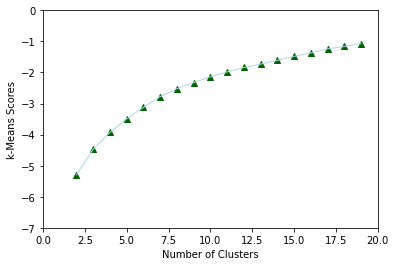

In [515]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.set(xlim=[0,20],ylim=[-7,0])
#plt.xlim([2, 20])
ax.plot(x, kscores, color='lightblue', linewidth=1)
ax.scatter(x,kscores,
color='darkgreen',
marker='^')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("k-Means Scores")

Text(0, 0.5, 'Inertia Scores')

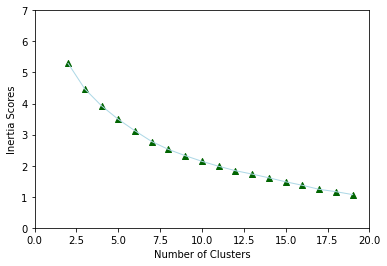

In [516]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.set(xlim=[0,20],ylim=[0,7])
ax.plot(x, kinertia, color='lightblue', linewidth=1)
ax.scatter(x,kinertia,
color='darkgreen',
marker='^')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Inertia Scores")

Unfortuantely there is a poorly defined "elbow-point" on both graphs, so it is difficult to tell.  It appears that the "elbow point" is around 7 clusters.

Now, let's run the algorithm again with the optimal number of clusters: 7

In [517]:
# set number of clusters
kclusters = 7

kmeans_8_model = KMeans(n_clusters=kclusters, 
                init='k-means++', 
                n_init=100,
                max_iter=5000,
                tol=0.001, 
                random_state=12)
kmeans_8 = kmeans_8_model.fit_predict(joburg_grouped_clustering)
kmeans_8

array([5, 4, 5, 4, 2, 0, 1, 1, 2, 1, 4, 0, 2, 4, 3, 3, 1, 4, 2, 5, 6, 0,
       2, 4, 3, 5, 3, 1, 3, 2, 2, 4, 5, 5, 2, 2, 3, 5, 3, 2, 3, 5, 1, 1,
       4, 5, 6, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighbourhood.

It will have:

1. df - suburb names along with geospacial data
2. neighbourhood_venues_sorted - suburb names along with the 10 most common venues.
3. kmeans_8_model.labels_ - cluster labels


In [518]:
neighbourhoods_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"( Auckland Park,)",Indian Restaurant,African Restaurant,Restaurant,Latin American Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant
1,"( Bedfordview,)",Restaurant,Greek Restaurant,Italian Restaurant,Sushi Restaurant,Middle Eastern Restaurant,German Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Asian Restaurant
2,"( Braamfontein,)",Restaurant,African Restaurant,Asian Restaurant,Ethiopian Restaurant,Indian Restaurant,Latin American Restaurant,American Restaurant,Chinese Restaurant,Eastern European Restaurant,Fast Food Restaurant
3,"( Bramley,)",Italian Restaurant,Seafood Restaurant,Restaurant,Middle Eastern Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant
4,"( Bryanston,)",Italian Restaurant,Indian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant


In [519]:
joburg_merged = df

In [520]:
joburg_merged.head()

,Suburb,Latitude,Longitude
3,[ Roodepoort],-26.1908,27.9486
4,[ Westonaria],-26.3492,27.7731
5,[ Sandton],-26.1047,28.045
6,[ Randburg],-26.0961,27.975
7,[ Rivonia],-26.1166,28.0464


In [521]:
# Turn unhashable list into tuple

joburg_merged['Suburb'] = joburg_merged['Suburb'].apply(lambda x: tuple(x))
joburg_merged.head()

,Suburb,Latitude,Longitude
3,"( Roodepoort,)",-26.1908,27.9486
4,"( Westonaria,)",-26.3492,27.7731
5,"( Sandton,)",-26.1047,28.045
6,"( Randburg,)",-26.0961,27.975
7,"( Rivonia,)",-26.1166,28.0464


In [522]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_8_model.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighbourhood
joburg_merged = joburg_merged.join(neighbourhoods_venues_sorted.set_index('Suburb'), on='Suburb')

In [523]:
joburg_merged.head(5)

,Suburb,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"( Roodepoort,)",-26.1908,27.9486,5,African Restaurant,Indian Restaurant,Asian Restaurant,Restaurant,Italian Restaurant,Latin American Restaurant,American Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant
4,"( Westonaria,)",-26.3492,27.7731,6,Portuguese Restaurant,Fast Food Restaurant,Seafood Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant
5,"( Sandton,)",-26.1047,28.045,3,Seafood Restaurant,Italian Restaurant,Tapas Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Asian Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant
6,"( Randburg,)",-26.0961,27.975,2,Italian Restaurant,German Restaurant,Indian Restaurant,Fast Food Restaurant,Portuguese Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant
7,"( Rivonia,)",-26.1166,28.0464,3,Seafood Restaurant,Italian Restaurant,Tapas Restaurant,Chinese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Asian Restaurant,Eastern European Restaurant,Ethiopian Restaurant


Let's remove rows with NaN values.

In [524]:
joburg_merged[joburg_merged['Cluster Labels'].isna()]

,Suburb,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [525]:
joburg_merged = joburg_merged.dropna(axis = 0, how = 'any')
joburg_merged.head()

,Suburb,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"( Roodepoort,)",-26.1908,27.9486,5,African Restaurant,Indian Restaurant,Asian Restaurant,Restaurant,Italian Restaurant,Latin American Restaurant,American Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant
4,"( Westonaria,)",-26.3492,27.7731,6,Portuguese Restaurant,Fast Food Restaurant,Seafood Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant
5,"( Sandton,)",-26.1047,28.045,3,Seafood Restaurant,Italian Restaurant,Tapas Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Asian Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant
6,"( Randburg,)",-26.0961,27.975,2,Italian Restaurant,German Restaurant,Indian Restaurant,Fast Food Restaurant,Portuguese Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant
7,"( Rivonia,)",-26.1166,28.0464,3,Seafood Restaurant,Italian Restaurant,Tapas Restaurant,Chinese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Asian Restaurant,Eastern European Restaurant,Ethiopian Restaurant


In [526]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(joburg_merged['Latitude'], 
                                  joburg_merged['Longitude'], 
                                  joburg_merged['Suburb'], 
                                  joburg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

This clustering makes sense to anyone familiar with Johannesburg.  It has grouped the suburbs well.  

However, this is only comparing suburbs that are similar to each other based on the data received from the Four Square API.  Let's see how they are clustered after we add some weather data.

# DONE!

---

# Weather Info

The chosen weather API is:

weatherbit.io

It allows the input of latitudes and lingitudes, and provides historical data which will be used to get average weather conditions per suburb over a period of 4 years.  This historical range was determined by the weatherbit.io API key, which in this case is the free licence.

Once the historical data is collected, we will compress the data into average conditions.

In [527]:
baseURL = "http://api.weatherbit.io/v2.0/history/daily"

Supported Method: get

In [528]:
API_KEY = "9bbfe5dbb09b4dc887349bd700ae19bd" # Your API Key

In [529]:
start_date = "2021-04-20" # Enter the appropriate date

In [530]:
end_date = "2021-04-21" # Enter the appropriate date

Required Parameters:

1. lat (latitude)
2. lon (longitude)
3. start_date
4. end_date

Example Request:

https://api.weatherbit.io/v2.0/history/daily?postal_code=27601&country=US&start_date=2021-04-17&end_date=2021-04-18&key=API_KEY

Modify the cell below to use weatherbit.io API

In [531]:
URL = "https://api.weatherbit.io/v2.0/history/daily?postal_code=27601&country=US&start_date=2021-04-17&end_date=2021-04-18&key=API_KEY"

In [532]:
url = "https://api.weatherbit.io/v2.0/history/daily?&lat=38.123&lon=-78.543&start_date=2021-04-20&end_date=2021-04-21&key=9bbfe5dbb09b4dc887349bd700ae19bd"

In [533]:
# make the GET request
results = requests.get(url).json()

temp = results['data'][0]['temp']
max_temp = results['data'][0]['max_temp']
min_temp = results['data'][0]['min_temp']
max_wind_spd = results['data'][0]['max_wind_spd']
clouds = results['data'][0]['clouds']
precip = results['data'][0]['precip']

print("The weather conditions were:", "\n\n ")
print("Date:", start_date,",", end_date)
print("Temperature:", temp)
print("Max temperature:", max_temp)
print("Min temperature:", min_temp)
print("Max wind speed:", max_wind_spd)
print("Cloud cover:", clouds)
print("Rain:", precip)

The weather conditions were: 

 
Date: 2021-04-20 , 2021-04-21
Temperature: 16
Max temperature: 21.1
Min temperature: 7.2
Max wind speed: 10.3
Cloud cover: 18
Rain: 0


### Dates to use:

1st of each month.

In [534]:
start_dates1 = ["2020-01-01", 
               "2020-02-01", 
               "2020-03-01", 
               "2020-04-01", 
               "2020-05-01", 
               "2020-06-01", 
               "2020-07-01", 
               "2020-08-01", 
               "2020-09-01", 
               "2020-10-01", 
               "2020-11-01", 
               "2020-12-01"]
end_dates1 = ["2020-01-02",
             "2020-02-02", 
             "2020-03-02", 
             "2020-04-02", 
             "2020-05-02", 
             "2020-06-02", 
             "2020-07-02", 
             "2020-08-02", 
             "2020-09-02", 
             "2020-10-02", 
             "2020-11-02", 
             "2020-12-02"]

These dates were chosen to try to get as much weather data per year as possible.  However, my API key only allows for:

500 calls per day <br>
Maximum 4 years history <br>
<br>
This means that I can only get 4 years worth of historical data.  Because only 500 calls can be made per day, the plan is to get as much data as I can with 500 calls.  Currently, with 8 dates per suburb, 48 suburbs, we make 384 calls.

Obviously, because we're taking the average for each weather measure, the more data we have, the more accurate the results will be.  So taking the average over 10 years, getting daily weather data, will give us a much better average value.

Unfortunately, due to this being an academic project and not a funded project, the data is limited by the API key, which in this case is the free version.

---

___

___

In [535]:
start_dates = ["2017-01-01", "2017-07-01", "2018-01-01", "2018-07-01", "2019-01-01", "2019-07-01", "2020-01-01", "2020-07-01"]
end_dates = ["2017-01-02", "2017-07-02", "2018-01-02", "2018-07-02", "2019-01-02", "2019-07-02", "2020-01-02", "2020-07-02"]

In [536]:
weather_data = []
key = "9bbfe5dbb09b4dc887349bd700ae19bd"
def getWeatherData(names, latitudes, longitudes, start_dates, end_dates):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        for strdat, enddat in zip(start_dates, end_dates):
            url = 'https://api.weatherbit.io/v2.0/history/daily?&lat={}&lon={}&start_date={}&end_date={}&key={}'.format(
                lat, 
                lng, 
                strdat, 
                enddat, 
                key)
            
            results = requests.get(url).json()
            #print(results)
            start_date = strdat
            end_date = enddat
            temperature = results['data'][0]['temp']
            max_temp = results['data'][0]['max_temp']
            min_temp = results['data'][0]['min_temp']
            max_wind_spd = results['data'][0]['max_wind_spd']
            clouds = results['data'][0]['clouds']
            precip = results['data'][0]['precip']

            # return only relevant information for each nearby venue
            weather_data.append([
                name,
                start_date,
                end_date,
                temperature, 
                max_temp, 
                min_temp, 
                max_wind_spd, 
                clouds, 
                precip])

    weatherdf = pd.DataFrame([item for weather_data in weather_data for item in weather_data])
    weatherdf.columns = ['Suburb', 
                         'Temperature', 
                         'Max Tepmerature', 
                         'Min Tepmerature', 
                         'Max Wind Speed', 
                         'Min Wind Speed', 
                         'Cloud Cover',
                         'Precipitation']
    
    return(weatherdf)
print("Done!")

Done!


In [ ]:
joburg_weather = getWeatherData(names=df['Suburb'],
                           latitudes=df['Latitude'],
                           longitudes=df['Longitude'],
                           start_dates = start_dates,
                           end_dates = end_dates
                          )
print("Done!")

In [538]:
len(weather_data)

384

In [539]:
weather_data[0:16]

[[(' Roodepoort',), '2017-01-01', '2017-01-02', 18.5, 19, 18, 4.8, 3, 0],
 [(' Roodepoort',), '2017-07-01', '2017-07-02', 12.1, 19.1, 7.1, 7.2, 4, 0.4],
 [(' Roodepoort',), '2018-01-01', '2018-01-02', 24.6, 31.4, 18.9, 10.4, 0, 0],
 [(' Roodepoort',), '2018-07-01', '2018-07-02', 14.2, 22.3, 5.2, 6.8, 0, 0],
 [(' Roodepoort',),
  '2019-01-01',
  '2019-01-02',
  17.7,
  19.8,
  16.8,
  6.4,
  94,
  61.9],
 [(' Roodepoort',), '2019-07-01', '2019-07-02', 10.2, 17.9, 5, 14, 0, 0],
 [(' Roodepoort',), '2020-01-01', '2020-01-02', 21, 27.2, 15.6, 6.4, 51, 7.6],
 [(' Roodepoort',), '2020-07-01', '2020-07-02', 11.5, 17.9, 5.8, 7.2, 26, 0],
 [(' Westonaria',), '2017-01-01', '2017-01-02', 19.5, 20, 19, 5.2, 30, 0],
 [(' Westonaria',), '2017-07-01', '2017-07-02', 13.2, 20.4, 7.5, 5.6, 4, 0],
 [(' Westonaria',), '2018-01-01', '2018-01-02', 24.8, 30.9, 18.7, 10.4, 0, 0],
 [(' Westonaria',), '2018-07-01', '2018-07-02', 14.3, 22.3, 5.2, 8.4, 0, 0],
 [(' Westonaria',),
  '2019-01-01',
  '2019-01-02',
  

We can see from "weather_data", that for each suburb, we get weather data for 8 days over 4 years.  This is all the data that is needed.

Create a dictionary with suburb names as the keys.  The values will be the average values generated.

In [540]:
suburbs = {}
for key in df['Suburb']:
    suburbs[key] = None
suburbs

{(' Roodepoort',): None,
 (' Westonaria',): None,
 (' Sandton',): None,
 (' Randburg',): None,
 (' Rivonia',): None,
 (' Ruimsig',): None,
 (' Fourways',): None,
 (' Edenvale',): None,
 (' Bedfordview',): None,
 (' Southgate',): None,
 (' Auckland Park',): None,
 (' Germiston',): None,
 (' Northcliff',): None,
 (' Bryanston',): None,
 (' Fairland',): None,
 (' Honeydew',): None,
 (' Houghton',): None,
 (' Hyde Park',): None,
 (' Kensington',): None,
 (' Linden',): None,
 (' Melville',): None,
 (' Morningside',): None,
 (' Saxonwold',): None,
 (' Illovo',): None,
 (' Rosebank',): None,
 (' Melrose',): None,
 (' Mondeor',): None,
 (' Westdene',): None,
 (' Parkview',): None,
 (' Lanseria',): None,
 (' Parktown',): None,
 (' Lyndhurst',): None,
 (' Braamfontein',): None,
 (' Greenside',): None,
 (' Lonehill',): None,
 (' Kyalami',): None,
 (' Soweto',): None,
 (' Norwood',): None,
 (' North Riding',): None,
 (' Winchester Hills',): None,
 (' Cresta',): None,
 (' Eikenhof',): None,
 (' Bra

In [541]:
for row in range(0, len(weather_data), 8):
    try:
        # for each row, do something
        
        dictvals = []
        
        for column in range(3, len(weather_data[0])):
            try:
                avg = []
                name = weather_data[row][0]
                
                # get the values to sum
                value0 = weather_data[row + 0][column]
                value1 = weather_data[row + 1][column]
                value2 = weather_data[row + 2][column]
                value3 = weather_data[row + 3][column]
                value4 = weather_data[row + 4][column]
                value5 = weather_data[row + 5][column]
                value6 = weather_data[row + 6][column]
                value7 = weather_data[row + 7][column]
                #print(value0, value1, value2, value3, value4, value5, value6, value7)
                
                # get the average
                avgval = (value0 + value1 + value2 + value3 + value4 + value5 + value6 + value7)/8
                
                # append the average to SOMETHING
                dictvals.append(avgval)
                suburbs[name] = dictvals

            except:
                print("There is a problem with the columns")
            suburbs[name] = dictvals
    except:
        print("There is a problem with the rows")

In [542]:
len(suburbs)

48

In [543]:
suburbs[(' Roodepoort',)]

[16.225, 21.825, 11.549999999999999, 7.9, 22.25, 8.737499999999999]

---

---

---

---

___

Okay, now I've found the averages for all the suburbs.  It is now ready to combine with the DF that will be analyzed for the clustering.

Next Step:

Clustering

# DONE!

---

# Clustering

We will repeat the clustering algorithm on the new data.  Where before we did clustering based on the data received from the Four Square API, now we will combine the weather data with this data to see how it affected the clustering.

We need to combine the weather data with the foursquare data:

In [545]:
avgs_DF = pd.DataFrame.from_dict(suburbs, orient='index')
avgs_DF.head()

,0,1,2,3,4,5
"( Roodepoort,)",16.225,21.8250,11.5500,7.9,22.250,8.7375
"( Westonaria,)",16.325,22.4375,11.5250,8.2,21.625,3.6125
"( Sandton,)",16.075,22.3125,10.9875,7.9,22.250,8.7375
"( Randburg,)",16.225,21.8250,11.5500,7.9,22.250,8.7375
"( Rivonia,)",16.075,22.3125,10.9875,7.9,22.250,8.7375


Sort the index in descending order.

In [546]:
avgs_DF.sort_index(inplace=True)
avgs_DF.head()

,0,1,2,3,4,5
"( Auckland Park,)",16.225,21.8250,11.5500,7.9,22.25,8.7375
"( Bedfordview,)",15.875,21.9875,10.7750,7.9,22.25,8.7375
"( Braamfontein,)",16.075,22.3125,10.9875,7.9,22.25,8.7375
"( Bramley,)",16.075,22.3125,10.9875,7.9,22.25,8.7375
"( Bryanston,)",16.225,21.8250,11.5500,7.9,22.25,8.7375


In [547]:
avgs_DF.columns = ["Temperature - Average", "Temperature - Maximum", "Temperature - Minimum", "Wind Speed - Average", "Cloud Cover", "Rainfall - Average"]

In [548]:
avgs_DF.head()

,Temperature - Average,Temperature - Maximum,Temperature - Minimum,Wind Speed - Average,Cloud Cover,Rainfall - Average
"( Auckland Park,)",16.225,21.8250,11.5500,7.9,22.25,8.7375
"( Bedfordview,)",15.875,21.9875,10.7750,7.9,22.25,8.7375
"( Braamfontein,)",16.075,22.3125,10.9875,7.9,22.25,8.7375
"( Bramley,)",16.075,22.3125,10.9875,7.9,22.25,8.7375
"( Bryanston,)",16.225,21.8250,11.5500,7.9,22.25,8.7375


Since these dataframes are ordered differently, let's sort both by suburb name in descending order.

Make them the same length.

In [ ]:
len(avgs_DF), len(joburg_grouped)

In [550]:
avgs_DF.head()

,Temperature - Average,Temperature - Maximum,Temperature - Minimum,Wind Speed - Average,Cloud Cover,Rainfall - Average
"( Auckland Park,)",16.225,21.8250,11.5500,7.9,22.25,8.7375
"( Bedfordview,)",15.875,21.9875,10.7750,7.9,22.25,8.7375
"( Braamfontein,)",16.075,22.3125,10.9875,7.9,22.25,8.7375
"( Bramley,)",16.075,22.3125,10.9875,7.9,22.25,8.7375
"( Bryanston,)",16.225,21.8250,11.5500,7.9,22.25,8.7375


In [551]:
avgs_DF.reset_index(inplace = True)

In [552]:
avgs_DF.head()

,index,Temperature - Average,Temperature - Maximum,Temperature - Minimum,Wind Speed - Average,Cloud Cover,Rainfall - Average
0,"( Auckland Park,)",16.225,21.8250,11.5500,7.9,22.25,8.7375
1,"( Bedfordview,)",15.875,21.9875,10.7750,7.9,22.25,8.7375
2,"( Braamfontein,)",16.075,22.3125,10.9875,7.9,22.25,8.7375
3,"( Bramley,)",16.075,22.3125,10.9875,7.9,22.25,8.7375
4,"( Bryanston,)",16.225,21.8250,11.5500,7.9,22.25,8.7375


In [553]:
joburg_grouped.head()

,Suburb,African Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Portuguese Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,"( Auckland Park,)",0.250000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,"( Bedfordview,)",0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.111111,0.222222,0.111111,0.111111,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.222222,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0
2,"( Braamfontein,)",0.166667,0.000,0.166667,0.0,0.0,0.166667,0.0,0.0,0.000000,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,"( Bramley,)",0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.142857,0.000000,0.285714,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.285714,0.0,0.000000,0.0,0.0,0.0,0.0
4,"( Bryanston,)",0.000000,0.125,0.000000,0.0,0.0,0.000000,0.0,0.0,0.125000,0.000000,0.250000,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0


Before we combine these dataframes, let's normalize the values for weather so that they don't dominate the algorithm.

In [554]:
from sklearn import preprocessing

In [555]:
from sklearn import preprocessing

avgs_DF_norm=(avgs_DF - avgs_DF.mean())/avgs_DF.std()

In [ ]:
#weather_norm = avgs_DF_norm.drop(['Suburb'], axis=1)
#weather_norm.head()

In [557]:
len(avgs_DF_norm), len(joburg_grouped)

(48, 48)

Now that the lengths are the same and the data is normalized, these 2 DFs can be combined for modelling.

In [558]:
clustering_data = pd.concat([joburg_grouped, avgs_DF_norm], 
                            axis='columns',
                             ignore_index=False)

In [559]:
len(clustering_data)

48

In [560]:
clustering_data.head()

,Suburb,African Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Portuguese Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Cloud Cover,Rainfall - Average,Temperature - Average,Temperature - Maximum,Temperature - Minimum,Wind Speed - Average,index
0,"( Auckland Park,)",0.250000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,0.056394,-0.180770,0.244382,-0.337038,NaN
1,"( Bedfordview,)",0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.111111,0.222222,0.111111,0.111111,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.222222,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,-0.060857,0.445312,-0.170533,-0.077093,-0.204280,-0.337038,NaN
2,"( Braamfontein,)",0.166667,0.000,0.166667,0.0,0.0,0.166667,0.0,0.0,0.000000,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,-0.040861,0.130261,-0.081260,-0.337038,NaN
3,"( Bramley,)",0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.142857,0.000000,0.285714,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.285714,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,-0.040861,0.130261,-0.081260,-0.337038,NaN
4,"( Bryanston,)",0.000000,0.125,0.000000,0.0,0.0,0.000000,0.0,0.0,0.125000,0.000000,0.250000,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,0.056394,-0.180770,0.244382,-0.337038,NaN


Drop the last column: "index"

In [561]:
clustering_data.drop(labels = "index", inplace = True, axis = 1)

In [562]:
clustering_data.head()

,Suburb,African Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Portuguese Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Cloud Cover,Rainfall - Average,Temperature - Average,Temperature - Maximum,Temperature - Minimum,Wind Speed - Average
0,"( Auckland Park,)",0.250000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,0.056394,-0.180770,0.244382,-0.337038
1,"( Bedfordview,)",0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.111111,0.222222,0.111111,0.111111,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.222222,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,-0.060857,0.445312,-0.170533,-0.077093,-0.204280,-0.337038
2,"( Braamfontein,)",0.166667,0.000,0.166667,0.0,0.0,0.166667,0.0,0.0,0.000000,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,-0.040861,0.130261,-0.081260,-0.337038
3,"( Bramley,)",0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.142857,0.000000,0.285714,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.285714,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,-0.040861,0.130261,-0.081260,-0.337038
4,"( Bryanston,)",0.000000,0.125,0.000000,0.0,0.0,0.000000,0.0,0.0,0.125000,0.000000,0.250000,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,0.056394,-0.180770,0.244382,-0.337038


Let's drop rows with NaN values.

In [563]:
clustering_data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [564]:
len(clustering_data)

48

Now that the data is ready, let's run it through k-Means to see how the clustering was affected.

In [565]:
clustering_data.head()

,Suburb,African Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Portuguese Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Cloud Cover,Rainfall - Average,Temperature - Average,Temperature - Maximum,Temperature - Minimum,Wind Speed - Average
0,"( Auckland Park,)",0.250000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,0.056394,-0.180770,0.244382,-0.337038
1,"( Bedfordview,)",0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.111111,0.222222,0.111111,0.111111,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.222222,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,-0.060857,0.445312,-0.170533,-0.077093,-0.204280,-0.337038
2,"( Braamfontein,)",0.166667,0.000,0.166667,0.0,0.0,0.166667,0.0,0.0,0.000000,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,-0.040861,0.130261,-0.081260,-0.337038
3,"( Bramley,)",0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.142857,0.000000,0.285714,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.285714,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,-0.040861,0.130261,-0.081260,-0.337038
4,"( Bryanston,)",0.000000,0.125,0.000000,0.0,0.0,0.000000,0.0,0.0,0.125000,0.000000,0.250000,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0,-0.060857,0.445312,0.056394,-0.180770,0.244382,-0.337038


In [566]:
type(joburg_grouped_clustering)

pandas.core.frame.DataFrame

Run _k_-means to cluster the neighbourhood into 10 clusters.


In [567]:
# set number of clusters
kclusters = 4

clustering_data = clustering_data.drop('Suburb', 1)
#joburg_grouped_clustering = joburg_grouped.drop('Suburb', 1)

test_kmeans = KMeans(n_clusters=kclusters, 
                init='k-means++', 
                n_init=100,
                max_iter=5000,
                tol=0.001, 
                random_state=12)
test_labels = test_kmeans.fit_predict(clustering_data) #toronto_grouped_clustering
test_labels

array([0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0,
       2, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       1, 0, 3, 3])

In [568]:
# set number of clusters
kclusters = 10

#clustering_data = clustering_data.drop('Suburb', 1)
#joburg_grouped_clustering = joburg_grouped.drop('Suburb', 1)

test_kmeans = KMeans(n_clusters=kclusters, 
                init='k-means++', 
                n_init=100,
                max_iter=5000,
                tol=0.001, 
                random_state=12)
test_labels = test_kmeans.fit_predict(clustering_data) #toronto_grouped_clustering
test_labels

array([5, 4, 0, 4, 8, 8, 2, 2, 8, 4, 4, 8, 8, 4, 4, 0, 9, 4, 3, 9, 2, 8,
       3, 4, 4, 5, 3, 2, 7, 8, 8, 4, 0, 0, 8, 8, 4, 5, 4, 8, 4, 0, 2, 2,
       1, 5, 6, 2])

### What is the optimal value of k?

In [569]:
kclusters = 20
kinertia = []
for k in range(2, kclusters):
    kscore = KMeans(n_clusters=k, 
                init='k-means++', 
                n_init=100,
                max_iter=3000,
                tol=0.01, 
                random_state=7).fit(clustering_data)
    kinertia.append(kscore.inertia_)
    #print(kscore1)
print("The k-Inertias are:", kinertia)


The k-Inertias are: [69.24867363135033, 26.654267214753258, 10.745703950172011, 8.181949371972792, 6.099339721689544, 5.225620577112654, 4.483961926429655, 4.0277493198733065, 3.5352511701869775, 3.1089743434694763, 2.755623247168499, 2.408458561934836, 2.1460300856671344, 1.9571671574427987, 1.77849941972508, 1.6229617370594216, 1.470562419038115, 1.3265396219170684]


Let's graph number of clusters against kscores and kinertia

In [570]:
x = np.linspace(2, 19, 18)

Text(0, 0.5, 'Inertia Scores')

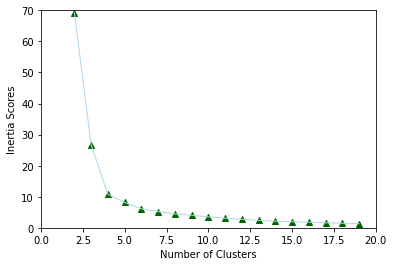

In [571]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.set(xlim=[0,20],ylim=[0,70])
ax.plot(x, kinertia, color='lightblue', linewidth=1)
ax.scatter(x,kinertia,
color='darkgreen',
marker='^')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Inertia Scores")

Luckily there is a clearly defined elbow-point at 4 clusters.

Now, let's run the algorithm again with the optimal number of clusters: 4

In [572]:
kinertia[0] - kinertia[1], kinertia[2] - kinertia[3], kinertia[4] - kinertia[5], kinertia[6] - kinertia[7]

(42.59440641659707, 2.5637545781992195, 0.8737191445768904, 0.4562126065563481)

In [574]:
# set number of clusters
kclusters = 5

kmeans_5_model = KMeans(n_clusters=kclusters, 
                init='k-means++', 
                n_init=100,
                max_iter=50000,
                tol=0.001, 
                random_state=7)
kmeans_5 = kmeans_5_model.fit_predict(clustering_data)
kmeans_5

array([4, 0, 0, 0, 4, 4, 2, 2, 4, 0, 0, 4, 4, 0, 0, 0, 0, 0, 3, 0, 2, 4,
       3, 0, 0, 4, 3, 2, 3, 4, 4, 0, 0, 0, 4, 4, 0, 4, 0, 4, 0, 0, 2, 2,
       1, 4, 2, 2])

In [576]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(joburg_merged['Latitude'], 
                                  joburg_merged['Longitude'], 
                                  joburg_merged['Suburb'], 
                                  kmeans_5):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [577]:
sum(kmeans_5 == 0)

20

This clustering is less useful because it has increased the number of suburbs similar to Sandton.

Where, before, the number of suburbs similar to Sandton was equal to 3, now it is equal to 20.

The only difference between the data used before and now is the inclusion of the weather data.  I normalized the weather data so that it would be comparable to the Four Square data.  However, I think that simple normalization was incorrect since the frequency data from Four Square are only positive values and the normalized weather data are both positive and negative.  

Another possible explanation is the number of features added when adding the weather data.  That being said, the weather data is very limited since we could only receive 2 readings for the year for each suburb over 4 years due to my current API key.  This means that it is likely that the weather data a skewed.  So test and rectify this, one could either run this process over a few days to increase the number of data points for each year, or an upgraded API key could be purchased, meaning that the limits would be less stringent.

Yet another possibility was the way in which the weather data was processes into usable information.  In this case it was a simple average.  But one could combine the desired weather measures into a single value.

Better results would also be achieved if more features are added.  In this case, since it is a restaurant, one could add demographic, economic, and traffic information.  But again, due to time and resource restrictions, I analyzed the data that I had access to.  Increasing the scope of data I can add would lead to more meaningful results.

___